In [1]:
import pandas as pd
import numpy as np

from google.oauth2 import service_account
from google.cloud import bigquery

In [2]:
SERVICE_ACCOUNT_FILE = "./key/api_key_carsharing.json"  # 키 json 파일
credentials = service_account.Credentials.from_service_account_file(SERVICE_ACCOUNT_FILE)
project_id = "carsharing-454809"
dataset_name = "carsharing"
client = bigquery.Client(credentials=credentials, project=project_id)

def import_bigquery_data(query):
    query_job = client.query(query)
    return query_job.to_dataframe()

In [3]:
query1 = (f"""select * from {project_id}.{dataset_name}.licenses""")
query2 = (f"""select * from {project_id}.{dataset_name}.greencars""")
query3 = (f"""select * from {project_id}.{dataset_name}.transports""")
query4 = (f"""select * from {project_id}.{dataset_name}.sites""")

In [4]:
df2_licenses = import_bigquery_data(query1)
filtered_df1_greencar = import_bigquery_data(query2)
df3_transport = import_bigquery_data(query3)
df4_poi = import_bigquery_data(query4)
top_100 = df4_poi.head(100)

In [5]:
region_total_mapping = {
    '서울특별시': ['서울']+sorted([
                        "종로구", "중구", "용산구", "성동구", "광진구", "동대문구", "중랑구", 
                        "성북구", "강북구", "도봉구", "노원구", "은평구", "서대문구", "마포구", 
                        "양천구", "강서구", "구로구", "금천구", "영등포구", "동작구", "관악구", 
                        "서초구", "강남구", "송파구", "강동구"
                        ], reverse=True),
    '세종특별자치시':["세종"],
    '부산광역시': ["부산"],
    '대구광역시': ['대구'],
    '인천광역시': ['인천'],
    '광주광역시': ["광주광역시"],
    '대전광역시': ["대전"],
    '울산광역시': ["울산"],
    '광주광역시': ["광주"],
    '경기도': ['경기', '수원시', '고양시', '화성시', '성남시', '용인시', '부천시', '안양시', '시흥시', '기타 경기도 지역'],
    '강원도': ['강원', '춘천시', '강릉시', '원주시', '기타 강원도 지역'],
    '경상남도': ['경남', '창원시', '김해시', '기타 경상남도 지역'],
    '경상북도': ['경북', '포항시', '경주시', '기타 경상북도 지역'],
    '전라남도': ['전남', '여수시', '순천시', '목포시', '기타 전라남도 지역'],
    '전라북도': ['전북', '전주시', '군산시', '익산시', '기타 전라북도 지역'],
    '충청남도': ['충남', '천안시', '아산시', '기타 충청남도 지역'],
    '충청북도': ['충북', '청주시', '충주시', '기타 충청북도 지역'],
    '제주특별자치도': ['제주', '서귀포']}

In [6]:
# 주소 encoding 컬럼 추출
address_columns = [
    col for col in filtered_df1_greencar.columns
    if col not in ['zoneName', 'address', 'latitude', 'longitude', 'cluster', 'core', 'radius']
]

# 각 주소 컬럼별 차고지 갯수 계산
garage_counts = {
    col: filtered_df1_greencar[col].sum() for col in address_columns
}

# 결과를 DataFrame으로 변환
df_garage = pd.DataFrame(list(garage_counts.items()), columns=['Region', 'Garage_Count'])
df_garage = df_garage.sort_values(by='Garage_Count', ascending=False).reset_index(drop=True)

address_list = list(region_total_mapping.keys())
df_garage = df_garage[df_garage['Region'].isin(address_list)]
df_garage


,Region,Garage_Count
0,서울특별시,491
1,경기도,446
3,부산광역시,153
4,인천광역시,137
5,경상북도,93
6,대구광역시,91
7,경상남도,90
8,광주광역시,68
11,충청남도,46
12,전라남도,45


In [7]:
import altair as alt

# 막대 그래프 생성
chart = alt.Chart(df_garage).mark_bar().encode(
    x=alt.X('Garage_Count:Q', title='Garage Count'),
    y=alt.Y('Region:O', sort='-x', title='Region'),  # 내림차순 정렬
    tooltip=['Region', 'Garage_Count']  # Tooltip에 추가 정보 표시
).properties(
    title='Garage Count by Address',
    width=800,
    height=800
)

chart

alt.Chart(...)

In [8]:
df_garage_licenses = pd.merge(df_garage, df2_licenses, on='Region', how='outer')
df_garage_licenses['license'] = df_garage_licenses['license'].astype(int)
df_garage_licenses

,Region,Garage_Count,license
0,서울특별시,491,6024859
1,경기도,446,8708245
2,부산광역시,153,1883885
3,인천광역시,137,1823597
4,경상북도,93,1528795
5,대구광역시,91,1461003
6,경상남도,90,1940391
7,광주광역시,68,866628
8,충청남도,46,1266080
9,전라남도,45,987358


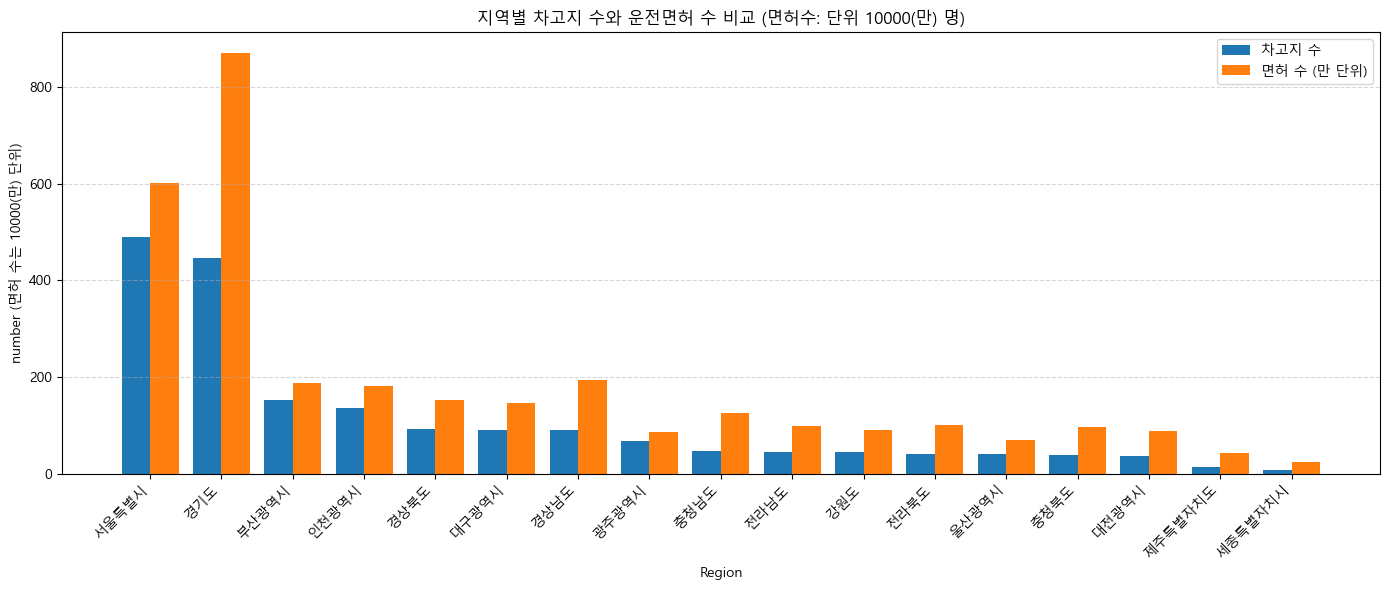

In [9]:
import matplotlib.pyplot as plt

# 한글 폰트 설정 (윈도우 기준)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 데이터프레임 이름: df_garage_licenses
x = np.arange(len(df_garage_licenses))
bar_width = 0.4

# 면허 수 천 단위로 나누기
license_scaled = df_garage_licenses['license'] / 10000  # 단위: 만 명

plt.figure(figsize=(14, 6))

# 차고지 수
plt.bar(x - bar_width/2, df_garage_licenses['Garage_Count'], width=bar_width, label='차고지 수')

# 면허 수 (단위 조정)
plt.bar(x + bar_width/2, license_scaled, width=bar_width, label='면허 수 (만 단위)')

# x축 설정
plt.xticks(x, df_garage_licenses['Region'], rotation=45, ha='right')
plt.xlabel('Region')
plt.ylabel('number (면허 수는 10000(만) 단위)')
plt.title('지역별 차고지 수와 운전면허 수 비교 (면허수: 단위 10000(만) 명)')
plt.legend()
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()


In [10]:
df_garage_licenses["relative_Garage_Count"] = df_garage_licenses["Garage_Count"]/df_garage_licenses["Garage_Count"].max()
df_garage_licenses["relative_license"] = df_garage_licenses["license"]/df_garage_licenses["license"].max()
df_garage_licenses["relative_score"] = (df_garage_licenses["relative_Garage_Count"])/df_garage_licenses["relative_license"]


In [11]:
# 점 그래프: Garage_Count vs license
scatter_chart = alt.Chart(df_garage_licenses).mark_circle(size=100).encode(
    x=alt.X('Garage_Count:Q', title='Garage Count'),
    y=alt.Y('license:Q', title='License Count'),
    color=alt.Color('Region:N', title='Region'),
    tooltip=['Region', 'Garage_Count', 'license']
).properties(
    title='Garage Count vs License Count',
    width=800,
    height=400
)

scatter_chart


alt.Chart(...)

In [12]:
def generate_circle(lat, lon, radius, n_points=50):
    """
    중심 좌표(lat, lon)와 반경(radius)를 이용해 원형 다각형의 좌표를 생성.
    :param lat: 위도
    :param lon: 경도
    :param radius: 반경 (미터 단위)
    :param n_points: 다각형을 구성할 점의 수
    :return: 원형 다각형의 좌표 리스트
    """
    angles = np.linspace(0, 2 * np.pi, n_points)
    earth_radius = 6371000  # 지구 반경 (미터)
    
    # 위도와 경도의 단위를 라디안으로 변환
    lat_radians = np.radians(lat)
    lon_radians = np.radians(lon)
    
    circle_coords = []
    for angle in angles:
        d_lat = radius / earth_radius * np.cos(angle)
        d_lon = radius / (earth_radius * np.cos(lat_radians)) * np.sin(angle)
        
        new_lat = lat_radians + d_lat
        new_lon = lon_radians + d_lon
        
        circle_coords.append([np.degrees(new_lon), np.degrees(new_lat)])
    
    return circle_coords

In [13]:
import hdbscan

# 1. 위도와 경도 데이터 선택
coords = filtered_df1_greencar[['latitude', 'longitude']].dropna()

# HDBSCAN 모델 학습 (coords는 위도와 경도 데이터)
hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=5, metric='euclidean')
hdbscan_model.fit(coords)

# 클러스터 레이블 추가
filtered_df1_greencar['cluster'] = hdbscan_model.labels_

# 코어 멤버 여부 추가
filtered_df1_greencar['core'] = hdbscan_model.probabilities_ == 1

# 코어 멤버만 필터링
core_members = filtered_df1_greencar[filtered_df1_greencar['core']]

# 결과 확인
print(f"Number of core members: {len(core_members)}")
print(core_members.head())
# 결과 확인
num_clusters = len(set(hdbscan_model.labels_)) - (1 if -1 in hdbscan_model.labels_ else 0)
print(f"Number of clusters found: {num_clusters}")
print(filtered_df1_greencar['cluster'].value_counts())

Number of core members: 843
       zoneName                  address  latitude  longitude  서울특별시  세종특별자치시  \
1   울산시외버스터미널 뒤         울산 남구 달동 1301-11    35.536    129.338      0        0   
2      서부여성회관 옆            인천시 서구 서달로 16    37.500    126.679      0        0   
8      롯데마트 상록점  경기도 안산시 상록구 반석로 20(본오동)    37.297    126.861      0        0   
9      당리역 2번출구            부산 사하구 하단동 80    35.103    128.970      0        0   
10     소사역 1번출구       경기 부천시 소사구 경인로 349    37.483    126.795      0        0   

    부산광역시  대구광역시  인천광역시  광주광역시  ...  기타 경기도 지역  기타 강원도 지역  기타 경상남도 지역  \
1       0      0      0      0  ...          0          0           0   
2       0      0      1      0  ...          0          0           0   
8       0      0      0      0  ...          1          0           0   
9       1      0      0      0  ...          0          0           0   
10      0      0      0      0  ...          0          0           0   

    기타 경상북도 지역  기타 전라남도 지역  기타 전라북도 지역  기타 충청남

In [14]:
# 1. 위도와 경도 데이터 선택
coords = df3_transport[['latitude', 'longitude']].dropna()

# HDBSCAN 모델 학습 (coords는 위도와 경도 데이터)
hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=5, metric='euclidean')
hdbscan_model.fit(coords)

# 클러스터 레이블 추가
df3_transport['cluster'] = hdbscan_model.labels_

# 코어 멤버 여부 추가
df3_transport['core'] = hdbscan_model.probabilities_ == 1
# 코어 멤버만 필터링
transport_core_members = df3_transport[df3_transport['core']]

# 결과 확인
print(f"Number of core members: {len(transport_core_members)}")
print(transport_core_members.head())
# 결과 확인
num_clusters = len(set(hdbscan_model.labels_)) - (1 if -1 in hdbscan_model.labels_ else 0)
print(f"Number of clusters found: {num_clusters}")
print(filtered_df1_greencar['cluster'].value_counts())

Number of core members: 52677
        POI_NM CTPRVN_NM SIGNGU_NM LEGALDONG_NM LI_NM  longitude  latitude  \
1    청주시외버스터미널      충청북도   청주시 흥덕구          가경동     0    127.432    36.625   
2      터미널지하차도      충청북도   청주시 흥덕구          가경동     0    127.430    36.626   
3   시외버스터미널사거리      충청북도   청주시 흥덕구          가경동     0    127.431    36.625   
4      시외버스터미널      충청북도   청주시 흥덕구          가경동     0    127.432    36.625   
15    죽림동버스정류장      충청북도   청주시 흥덕구          가경동     0    127.440    36.612   

    cluster  core  
1      4591  True  
2      4591  True  
3      4591  True  
4      4591  True  
15     4584  True  
Number of clusters found: 6472
cluster
-1     408
 17    158
 9      72
 26     50
 70     46
      ... 
 55      6
 40      6
 28      6
 41      5
 56      5
Name: count, Length: 81, dtype: int64


In [15]:
import pydeck as pdk

# GreenCar 데이터 Layer
greencar_layer = pdk.Layer(
    "ScatterplotLayer",
    data=filtered_df1_greencar,
    get_position=["longitude", "latitude"],
    get_fill_color=[0, 255, 0, 160],  # Green color with transparency
    get_radius=700,
)
print(len(filtered_df1_greencar))
# sites 데이터 Layer
sites_layer = pdk.Layer(
    "ScatterplotLayer",
    data=df4_poi,
    get_position=["longitude", "latitude"],
    get_fill_color=[255, 0, 255, 255],  # Pink color with transparency
    get_radius=1000,
)
print(len(df4_poi))
# Transport 데이터 Layer
transport_layer = pdk.Layer(
    "ScatterplotLayer",
    data=df3_transport,
    get_position=["longitude", "latitude"],
    get_fill_color=[0, 0, 255, 100],  # Blue color with transparency
    get_radius=500,
)
print(len(df3_transport))
# View 설정
view_state = pdk.ViewState(
    latitude=filtered_df1_greencar["latitude"].mean(),
    longitude=filtered_df1_greencar["longitude"].mean(),
    zoom=7,
)

# Pydeck Deck 생성
r = pdk.Deck(
    layers=[transport_layer, sites_layer, greencar_layer],
    initial_view_state=view_state,
)


1862
378
142937


In [16]:
import altair as alt

# Altair 데이터 제한 해제
alt.data_transformers.disable_max_rows()

top_10 = df4_poi.head(10)

# Altair로 시각화
chart = (
    alt.Chart(top_10)
    .mark_bar(size=40)
    .encode(
        y=alt.Y(
            "POI_NM:N",
            title=None,
            sort=alt.EncodingSortField(
                field="SCCNT_VALUE",  # 정렬 기준 열
                order="descending",  # 내림차순 정렬
            ),
        ),
        x=alt.X("SCCNT_VALUE:Q", title="검색량", sort="ascending"),
        color=alt.Color(
            "SCCNT_VALUE:Q",  # 수치형 값에 따라 색상 매핑
            scale=alt.Scale(
                domain=[top_10["SCCNT_VALUE"].min(), top_10["SCCNT_VALUE"].max()],
                range=["blue","black"],
            ),  # 검은색에서 파란색 그라데이션
            legend=alt.Legend(title="검색량"),  # 범례 제목 설정
        ),
        tooltip=["POI_NM", "SCCNT_VALUE"],  # 툴팁 정보
    )
    .properties(
        title=alt.TitleParams(
            text="검색 키워드 Top 10",
            align="left",
            anchor="start",
            fontSize=30,
            color="white",
        ),
        width=1000,
        height=600,
        background="white",
    )
    .configure_axis(
        labelColor="black",
        titleColor="black",
    )
    .configure_legend(
        titleColor="black",
        labelColor="black",
    )
)

# 시각화 표시
chart.display()


alt.Chart(...)

In [17]:
top_100

,POI_NM,address,middle category,small category,SCCNT_VALUE,latitude,longitude
0,설악케이블카,강원 속초시 설악산로 1085,기타관광,기타관광,166921,38.169120,128.520795
1,순천만국가정원,전남 순천시 국가정원1호길 47,기타관광,기타관광,141803,34.927400,127.502308
2,마장호수출렁다리,경기 파주시,기타관광,기타관광,130606,37.759895,126.780150
3,두물머리,경기 양평군,기타관광,기타관광,124463,37.491600,127.487500
4,독일마을,경남 남해군 독일로 92,기타관광,기타관광,105928,34.800799,128.038183
...,...,...,...,...,...,...,...
95,국립해양박물관,부산 영도구 해양로301번길 45,문화관광,전시시설,82802,35.078653,129.080258
96,수원메쎄,경기 수원시 권선구 세화로134번길 37,문화관광,전시시설,77446,37.264789,126.996520
97,에버랜드,경기 용인시 처인구 에버랜드로 199,문화관광,테마공원,912767,37.293475,127.202479
98,롯데월드잠실점,서울 송파구 올림픽로 240,문화관광,테마공원,353336,37.511499,127.098239


In [18]:
filtered_df1_greencar

,zoneName,address,latitude,longitude,서울특별시,세종특별자치시,부산광역시,대구광역시,인천광역시,광주광역시,...,기타 경기도 지역,기타 강원도 지역,기타 경상남도 지역,기타 경상북도 지역,기타 전라남도 지역,기타 전라북도 지역,기타 충청남도 지역,기타 충청북도 지역,cluster,core
0,롯데마트 삼계점 뒤편,경남 창원시 마산회원구 내서읍 삼계6길 26,35.233,128.504,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-1,False
1,울산시외버스터미널 뒤,울산 남구 달동 1301-11,35.536,129.338,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,22,True
2,서부여성회관 옆,인천시 서구 서달로 16,37.500,126.679,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,52,True
3,숭실대학교 학생회관,서울특별시 동작구 상도로 369(상도동),37.497,126.957,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-1,False
4,평거휴먼시아3단지 옆,경남 진주시 남강로309번길 44,35.171,128.061,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,6,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1857,여수엑스포역KTX(국제관 B동),전라남도 여수시 박람회길 1(덕충동),34.752,127.747,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,5,False
1858,탄방역 1번출구,대전 서구 문정로10번길 40,36.344,127.383,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,32,True
1859,경기도 이천시,경기도 이천시 고담동 67-11,37.251,127.473,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,24,True
1860,경기도 양주시,경기도 양주시 광적면 부흥로 847,37.817,126.988,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,-1,False


In [19]:
core_members.to_csv("./greencar_core1.csv")

In [20]:
transport_core_members

,POI_NM,CTPRVN_NM,SIGNGU_NM,LEGALDONG_NM,LI_NM,longitude,latitude,cluster,core
1,청주시외버스터미널,충청북도,청주시 흥덕구,가경동,0,127.432,36.625,4591,True
2,터미널지하차도,충청북도,청주시 흥덕구,가경동,0,127.430,36.626,4591,True
3,시외버스터미널사거리,충청북도,청주시 흥덕구,가경동,0,127.431,36.625,4591,True
4,시외버스터미널,충청북도,청주시 흥덕구,가경동,0,127.432,36.625,4591,True
15,죽림동버스정류장,충청북도,청주시 흥덕구,가경동,0,127.440,36.612,4584,True
...,...,...,...,...,...,...,...,...,...
142929,홍천사거리,강원특별자치도,홍천군,홍천읍,희망리,127.880,37.689,1079,True
142930,홍천터미널,강원특별자치도,홍천군,홍천읍,희망리,127.879,37.689,1079,True
142932,홍천터미널버스정류장,강원특별자치도,홍천군,홍천읍,희망리,127.879,37.689,1079,True
142934,홍천종합버스터미널버스정류장,강원특별자치도,홍천군,홍천읍,희망리,127.878,37.689,1079,True


In [21]:
from sklearn.neighbors import BallTree

def compute_nearby_counts(base_df, target_df, radius_km, lat_col='latitude', lon_col='longitude'):
    # 위도/경도 → 라디안
    base_coords = np.radians(base_df[[lat_col, lon_col]].values)
    target_coords = np.radians(target_df[[lat_col, lon_col]].values)

    # BallTree 생성 (Haversine metric)
    tree = BallTree(target_coords, metric='haversine')

    # 거리 km → 라디안
    radius = radius_km / 6371.0

    # 근처 개수 계산
    counts = tree.query_radius(base_coords, r=radius, count_only=True)

    # 자기 자신이 포함되었을 경우 조정 (원래 목적 따라 조절)
    return counts

In [22]:
top_100['near_transport_core_num'] = compute_nearby_counts(top_100, df3_transport[df3_transport['core']], radius_km=10)
top_100['near_car_core_num'] = compute_nearby_counts(top_100, filtered_df1_greencar[filtered_df1_greencar['core']], radius_km=10)
top_100['near_sites_core_num'] = compute_nearby_counts(top_100, top_100, radius_km=10)

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_64652\4252207663.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_100['near_transport_core_num'] = compute_nearby_counts(top_100, df3_transport[df3_transport['core']], radius_km=10)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_64652\4252207663.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_100['near_car_core_num'] = compute_nearby_counts(top_100, filtered_df1_greencar[filtered_df1_greencar['core']], radius_km=10)
C:\Users\Pub

In [23]:
import torch

# CUDA or CPU 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [57]:
# 전체 RankNet 파이프라인 통합 코드

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import random
import optuna

# -------------------- 모델 정의 --------------------
class RankNet(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.score_fn = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(16, 1)
        )

    def forward(self, x1, x2):
        s1 = self.score_fn(x1)
        s2 = self.score_fn(x2)
        return s1, s2


# -------------------- 평가 함수 --------------------
def ndcg_at_k(y_true, y_score, k=5):
    order = np.argsort(y_score)[::-1]
    y_true_sorted = np.take(y_true, order[:k])
    dcg = np.sum([(2**rel - 1) / np.log2(i + 2) for i, rel in enumerate(y_true_sorted)])
    ideal_sorted = np.sort(y_true)[::-1][:k]
    idcg = np.sum([(2**rel - 1) / np.log2(i + 2) for i, rel in enumerate(ideal_sorted)])
    return dcg / idcg if idcg > 0 else 0.0


def evaluate_pairwise_accuracy(X, model, num_pairs=300):
    correct = 0
    total = 0

    for _ in range(num_pairs):
        i, j = random.sample(range(len(X)), 2)
        xi = X[i].unsqueeze(0)
        xj = X[j].unsqueeze(0)

        with torch.no_grad():
            pred_score_i = model.score_fn(xi).item()
            pred_score_j = model.score_fn(xj).item()

        true_score_i = xi[0][0] - xi[0][1] + xi[0][2] + xi[0][3]
        true_score_j = xj[0][0] - xj[0][1] + xj[0][2] + xj[0][3]
        true_label = 1 if true_score_i > true_score_j else 0
        pred_label = 1 if pred_score_i > pred_score_j else 0

        if pred_label == true_label:
            correct += 1
        total += 1

    return correct / total


# ---------------- 입력 데이터 처리 -------------------
def create_pairs(top_100, device, num_pairs=1000):
    features = ['near_sites_core_num', 'near_transport_core_num', 'near_car_core_num', 'SCCNT_VALUE']
    X_raw = top_100[features].copy()

    # 모든 feature 정규화
    for col in features:
        min_val = X_raw[col].min()
        max_val = X_raw[col].max()
        X_raw[col] = (X_raw[col] - min_val) / (max_val - min_val + 1e-8)

    X_raw = X_raw.astype(np.float32)
    X = torch.tensor(X_raw.values, dtype=torch.float32).to(device)
    N = X.shape[0]

    pairs = []
    for _ in range(num_pairs):
        i, j = random.sample(range(N), 2)
        xi, xj = X[i], X[j]
        score_i = xi[0] - xi[1] + xi[2] + xi[3]
        score_j = xj[0] - xj[1] + xj[2] + xj[3]
        label = 1 if score_i > score_j else 0
        pairs.append((xi, xj, label))

    return X, pairs


# -------------------- 학습 함수 --------------------
def train_ranknet_model(pairs, input_dim, X, device):
    model = RankNet(input_dim).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)
    criterion = nn.BCEWithLogitsLoss()

    best_accuracy = 0
    patience = 5
    epochs_no_improve = 0
    accuracy_list = []

    for epoch in range(500):
        total_loss = 0
        for xi, xj, label in pairs:
            xi = xi.unsqueeze(0).to(device)
            xj = xj.unsqueeze(0).to(device)
            yi = torch.tensor([label], dtype=torch.float32).to(device)

            s1, s2 = model(xi, xj)
            pred = s1 - s2
            loss = criterion(pred.view(-1), yi)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        if epoch % 10 == 0:
            acc = evaluate_pairwise_accuracy(X, model, num_pairs=300)
            print(f"Epoch {epoch}, Loss: {total_loss:.4f}, Accuracy: {acc:.2%}")
            if acc > best_accuracy:
                best_accuracy = acc
                accuracy_list.append(best_accuracy)
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping at epoch {epoch}. Best accuracy: {best_accuracy:.2%}")
                break

    return model


# -------------------- Optuna 튜닝 --------------------
def tune_relevance_weights(top_100, model_scores, transport_mean):
    def objective(trial):
        w_site = trial.suggest_float('w_site', 0, 1)
        w_transport = trial.suggest_float('w_transport', 0, 1)
        w_car = trial.suggest_float('w_car', 0, 1)
        w_search = trial.suggest_float('w_search', 0, 1)

        total = w_site + w_transport + w_car + w_search + 1e-8
        w_site /= total
        w_transport /= total
        w_car /= total
        w_search /= total

        relevance = (
            w_site * top_100['near_sites_core_num'] +
            w_transport * (transport_mean - top_100['near_transport_core_num']) +
            w_car * (-top_100['near_car_core_num']) +
            w_search * top_100['SCCNT_VALUE']
        )

        relevance = (relevance - relevance.min()) / (relevance.max() - relevance.min() + 1e-8)

        return ndcg_at_k(relevance.values, model_scores, k=5)

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=50)
    return study.best_params, study.best_value


# -------------------- 평가 및 출력 --------------------
def evaluate_and_show_topk(top_100, model_scores, best_params, transport_mean):
    total = sum(best_params.values()) + 1e-8
    weights = {k: v / total for k, v in best_params.items()}

    top_100['relevance'] = (
        weights['w_site'] * top_100['near_sites_core_num'] +
        weights['w_transport'] * (transport_mean - top_100['near_transport_core_num']) +
        weights['w_car'] * (-top_100['near_car_core_num']) +
        weights['w_search'] * top_100['SCCNT_VALUE']
    )

    top_100['relevance'] = (top_100['relevance'] - top_100['relevance'].min()) / (top_100['relevance'].max() - top_100['relevance'].min() + 1e-8)

    ndcg = ndcg_at_k(top_100['relevance'].values, model_scores, k=5)
    top_k = top_100.sort_values(by='score', ascending=False).head(5)

    print(f"\n 최적 가중치 기반 nDCG: {ndcg:.4f}")
    print("\n 최적 가중치:")
    for k, v in weights.items():
        print(f"  {k}: {v:.3f}")

    print("\n 최종 Top-5 추천:")
    print(top_k[['POI_NM', 'score', 'relevance']])


# -------------------- 전체 파이프라인 --------------------
def run_pipeline(top_100, device):
    print("\n 입력 데이터 전처리 및 pair 생성 중...")
    X, pairs = create_pairs(top_100, device)
    transport_mean = top_100['near_transport_core_num'].mean()

    print("\n RankNet 모델 학습 시작...")
    model = train_ranknet_model(pairs, input_dim=X.shape[1], X=X, device=device)

    with torch.no_grad():
        scores = model.score_fn(X).squeeze().cpu().numpy()
        top_100['score'] = scores

    print("\n Optuna로 relevance 가중치 튜닝 중...")
    best_params, best_ndcg = tune_relevance_weights(top_100, scores, transport_mean)

    evaluate_and_show_topk(top_100, scores, best_params, transport_mean)

    print("\n 상관계수 (score vs relevance):")
    print(top_100[['score', 'relevance']].corr())


In [58]:
top_100_copy_relu1 = top_100.copy()
run_pipeline(top_100_copy_relu1, device)


 입력 데이터 전처리 및 pair 생성 중...

 RankNet 모델 학습 시작...
Epoch 0, Loss: 336.9321, Accuracy: 91.33%
Epoch 10, Loss: 183.1711, Accuracy: 95.33%
Epoch 20, Loss: 158.6869, Accuracy: 94.33%
Epoch 30, Loss: 144.9412, Accuracy: 97.33%
Epoch 40, Loss: 169.5220, Accuracy: 93.33%
Epoch 50, Loss: 150.2219, Accuracy: 94.00%
Epoch 60, Loss: 155.3653, Accuracy: 94.00%
Epoch 70, Loss: 147.9796, Accuracy: 94.67%


[I 2025-04-06 20:54:09,331] A new study created in memory with name: no-name-d584935d-18d0-42d0-ad63-8d6b61e8e48f
[I 2025-04-06 20:54:09,334] Trial 0 finished with value: 0.5853539021408547 and parameters: {'w_site': 0.4587829438099731, 'w_transport': 0.15122745170198548, 'w_car': 0.40659183488693806, 'w_search': 0.7032601778067877}. Best is trial 0 with value: 0.5853539021408547.
[I 2025-04-06 20:54:09,335] Trial 1 finished with value: 0.586241522220357 and parameters: {'w_site': 0.8781128366859587, 'w_transport': 0.387247523045108, 'w_car': 0.5037893593000466, 'w_search': 0.11128344361750575}. Best is trial 1 with value: 0.586241522220357.
[I 2025-04-06 20:54:09,337] Trial 2 finished with value: 0.5855457722890935 and parameters: {'w_site': 0.7655428622441729, 'w_transport': 0.43981734322508514, 'w_car': 0.4023276583546097, 'w_search': 0.4719617389614129}. Best is trial 1 with value: 0.586241522220357.
[I 2025-04-06 20:54:09,338] Trial 3 finished with value: 0.5865618653681485 and pa

Epoch 80, Loss: 151.3116, Accuracy: 95.67%
Early stopping at epoch 80. Best accuracy: 97.33%

 Optuna로 relevance 가중치 튜닝 중...


[I 2025-04-06 20:54:09,522] Trial 27 finished with value: 0.5855068186261778 and parameters: {'w_site': 0.45398264272205435, 'w_transport': 0.32826107697052376, 'w_car': 0.6601022068183898, 'w_search': 0.3993874126608634}. Best is trial 18 with value: 0.5964228960048598.
[I 2025-04-06 20:54:09,531] Trial 28 finished with value: 0.5856323596043561 and parameters: {'w_site': 0.5781687054250839, 'w_transport': 0.6997309656343473, 'w_car': 0.8860437202091703, 'w_search': 0.5301650138791378}. Best is trial 18 with value: 0.5964228960048598.
[I 2025-04-06 20:54:09,541] Trial 29 finished with value: 0.5858996406507845 and parameters: {'w_site': 0.41392042557837694, 'w_transport': 0.5419502120574706, 'w_car': 0.5911623265754045, 'w_search': 0.22911840450771365}. Best is trial 18 with value: 0.5964228960048598.
[I 2025-04-06 20:54:09,551] Trial 30 finished with value: 0.5853527224872516 and parameters: {'w_site': 0.7509829561688618, 'w_transport': 0.04729216926819202, 'w_car': 0.501966449298566


 최적 가중치 기반 nDCG: 0.5967

 최적 가중치:
  w_site: 0.234
  w_transport: 0.341
  w_car: 0.419
  w_search: 0.006

 최종 Top-5 추천:
   POI_NM      score  relevance
31  예술의전당  22.537952   0.276059
79    코엑스  22.313299   0.721841
43    서울숲  18.548395   0.140422
93  SETEC  14.877188   0.071979
97   에버랜드  14.747405        1.0

 상관계수 (score vs relevance):
              score  relevance
score      1.000000   0.406602
relevance  0.406602   1.000000


In [59]:
top_k_columns = ['POI_NM', 'address', 'middle category', 'small category', 'latitude', 'longitude', 'score']
top_k = top_100_copy_relu1.sort_values(by='score', ascending=False).head(5)
top_k[top_k_columns]

,POI_NM,address,middle category,small category,latitude,longitude,score
31,예술의전당,서울 서초구 남부순환로 2406,문화관광,공연시설,37.479747,127.013395,22.537952
79,코엑스,서울 강남구 영동대로 513,문화관광,전시시설,37.512527,127.058849,22.313299
43,서울숲,서울 성동구 뚝섬로 273,문화관광,도시공원,37.540206,127.017371,18.548395
93,SETEC,서울 강남구 남부순환로 3104,문화관광,전시시설,37.495795,127.071825,14.877188
97,에버랜드,경기 용인시 처인구 에버랜드로 199,문화관광,테마공원,37.293475,127.202479,14.747405


In [60]:
top_100_copy_relu1[['score', 'relevance']].corr()

,score,relevance
score,1.000000,0.406602
relevance,0.406602,1.000000


In [61]:
# hidden layer 추가

# -------------------- 모델 정의 --------------------
class RankNet(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.score_fn = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(32, 1)
        )

    def forward(self, x1, x2):
        s1 = self.score_fn(x1)
        s2 = self.score_fn(x2)
        return s1, s2


# -------------------- 평가 함수 --------------------
def ndcg_at_k(y_true, y_score, k=5):
    order = np.argsort(y_score)[::-1]
    y_true_sorted = np.take(y_true, order[:k])
    dcg = np.sum([(2**rel - 1) / np.log2(i + 2) for i, rel in enumerate(y_true_sorted)])
    ideal_sorted = np.sort(y_true)[::-1][:k]
    idcg = np.sum([(2**rel - 1) / np.log2(i + 2) for i, rel in enumerate(ideal_sorted)])
    return dcg / idcg if idcg > 0 else 0.0


def evaluate_pairwise_accuracy(X, model, num_pairs=300):
    correct = 0
    total = 0

    for _ in range(num_pairs):
        i, j = random.sample(range(len(X)), 2)
        xi = X[i].unsqueeze(0)
        xj = X[j].unsqueeze(0)

        with torch.no_grad():
            pred_score_i = model.score_fn(xi).item()
            pred_score_j = model.score_fn(xj).item()

        true_score_i = xi[0][0] - xi[0][1] + xi[0][2] + xi[0][3]
        true_score_j = xj[0][0] - xj[0][1] + xj[0][2] + xj[0][3]
        true_label = 1 if true_score_i > true_score_j else 0
        pred_label = 1 if pred_score_i > pred_score_j else 0

        if pred_label == true_label:
            correct += 1
        total += 1

    return correct / total


# ---------------- 입력 데이터 처리 -------------------
def create_pairs(top_100, device, num_pairs=1000):
    features = ['near_sites_core_num', 'near_transport_core_num', 'near_car_core_num', 'SCCNT_VALUE']
    X_raw = top_100[features].copy()

    # 모든 feature 정규화
    for col in features:
        min_val = X_raw[col].min()
        max_val = X_raw[col].max()
        X_raw[col] = (X_raw[col] - min_val) / (max_val - min_val + 1e-8)

    X_raw = X_raw.astype(np.float32)
    X = torch.tensor(X_raw.values, dtype=torch.float32).to(device)
    N = X.shape[0]

    pairs = []
    for _ in range(num_pairs):
        i, j = random.sample(range(N), 2)
        xi, xj = X[i], X[j]
        score_i = xi[0] - xi[1] + xi[2] + xi[3]
        score_j = xj[0] - xj[1] + xj[2] + xj[3]
        label = 1 if score_i > score_j else 0
        pairs.append((xi, xj, label))

    return X, pairs


# -------------------- 학습 함수 --------------------
def train_ranknet_model(pairs, input_dim, X, device):
    model = RankNet(input_dim).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)
    criterion = nn.BCEWithLogitsLoss()

    best_accuracy = 0
    patience = 5
    epochs_no_improve = 0
    accuracy_list = []

    for epoch in range(500):
        total_loss = 0
        for xi, xj, label in pairs:
            xi = xi.unsqueeze(0).to(device)
            xj = xj.unsqueeze(0).to(device)
            yi = torch.tensor([label], dtype=torch.float32).to(device)

            s1, s2 = model(xi, xj)
            pred = s1 - s2
            loss = criterion(pred.view(-1), yi)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        if epoch % 10 == 0:
            acc = evaluate_pairwise_accuracy(X, model, num_pairs=300)
            print(f"Epoch {epoch}, Loss: {total_loss:.4f}, Accuracy: {acc:.2%}")
            if acc > best_accuracy:
                best_accuracy = acc
                accuracy_list.append(best_accuracy)
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping at epoch {epoch}. Best accuracy: {best_accuracy:.2%}")
                break

    return model


# -------------------- Optuna 튜닝 --------------------
def tune_relevance_weights(top_100, model_scores, transport_mean):
    def objective(trial):
        w_site = trial.suggest_float('w_site', 0, 1)
        w_transport = trial.suggest_float('w_transport', 0, 1)
        w_car = trial.suggest_float('w_car', 0, 1)
        w_search = trial.suggest_float('w_search', 0, 1)

        total = w_site + w_transport + w_car + w_search + 1e-8
        w_site /= total
        w_transport /= total
        w_car /= total
        w_search /= total

        relevance = (
            w_site * top_100['near_sites_core_num'] +
            w_transport * (transport_mean - top_100['near_transport_core_num']) +
            w_car * (-top_100['near_car_core_num']) +
            w_search * top_100['SCCNT_VALUE']
        )

        relevance = (relevance - relevance.min()) / (relevance.max() - relevance.min() + 1e-8)

        return ndcg_at_k(relevance.values, model_scores, k=5)

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=50)
    return study.best_params, study.best_value


# -------------------- 평가 및 출력 --------------------
def evaluate_and_show_topk(top_100, model_scores, best_params, transport_mean):
    total = sum(best_params.values()) + 1e-8
    weights = {k: v / total for k, v in best_params.items()}

    top_100['relevance'] = (
        weights['w_site'] * top_100['near_sites_core_num'] +
        weights['w_transport'] * (transport_mean - top_100['near_transport_core_num']) +
        weights['w_car'] * (-top_100['near_car_core_num']) +
        weights['w_search'] * top_100['SCCNT_VALUE']
    )

    top_100['relevance'] = (top_100['relevance'] - top_100['relevance'].min()) / (top_100['relevance'].max() - top_100['relevance'].min() + 1e-8)

    ndcg = ndcg_at_k(top_100['relevance'].values, model_scores, k=5)
    top_k = top_100.sort_values(by='score', ascending=False).head(5)

    print(f"\n 최적 가중치 기반 nDCG: {ndcg:.4f}")
    print("\n 최적 가중치:")
    for k, v in weights.items():
        print(f"  {k}: {v:.3f}")

    print("\n 최종 Top-5 추천:")
    print(top_k[['POI_NM', 'score', 'relevance']])


# -------------------- 전체 파이프라인 --------------------
def run_pipeline(top_100, device):
    print("\n 입력 데이터 전처리 및 pair 생성 중...")
    X, pairs = create_pairs(top_100, device)
    transport_mean = top_100['near_transport_core_num'].mean()

    print("\n RankNet 모델 학습 시작...")
    model = train_ranknet_model(pairs, input_dim=X.shape[1], X=X, device=device)

    with torch.no_grad():
        scores = model.score_fn(X).squeeze().cpu().numpy()
        top_100['score'] = scores

    print("\n Optuna로 relevance 가중치 튜닝 중...")
    best_params, best_ndcg = tune_relevance_weights(top_100, scores, transport_mean)

    evaluate_and_show_topk(top_100, scores, best_params, transport_mean)

    print("\n 상관계수 (score vs relevance):")
    print(top_100[['score', 'relevance']].corr())


In [62]:
top_100_copy_relu2 = top_100.copy()
run_pipeline(top_100_copy_relu2, device)


 입력 데이터 전처리 및 pair 생성 중...

 RankNet 모델 학습 시작...
Epoch 0, Loss: 350.6621, Accuracy: 87.67%
Epoch 10, Loss: 211.1667, Accuracy: 91.00%
Epoch 20, Loss: 227.4075, Accuracy: 90.67%
Epoch 30, Loss: 207.1012, Accuracy: 92.00%
Epoch 40, Loss: 195.2960, Accuracy: 90.33%
Epoch 50, Loss: 208.9011, Accuracy: 91.67%
Epoch 60, Loss: 193.5789, Accuracy: 91.33%
Epoch 70, Loss: 199.4248, Accuracy: 94.00%
Epoch 80, Loss: 175.6723, Accuracy: 92.33%
Epoch 90, Loss: 193.7142, Accuracy: 91.33%
Epoch 100, Loss: 144.4822, Accuracy: 91.33%
Epoch 110, Loss: 155.4996, Accuracy: 91.67%


[I 2025-04-06 20:57:33,719] A new study created in memory with name: no-name-9bd47134-7aff-471b-9d82-7d0f4746d23b
[I 2025-04-06 20:57:33,723] Trial 0 finished with value: 0.1185753224175129 and parameters: {'w_site': 0.24614763595579958, 'w_transport': 0.2537093392538009, 'w_car': 0.9146054855476091, 'w_search': 0.2943076962642447}. Best is trial 0 with value: 0.1185753224175129.
[I 2025-04-06 20:57:33,724] Trial 1 finished with value: 0.11861298405344277 and parameters: {'w_site': 0.6226752064280174, 'w_transport': 0.38981102363197695, 'w_car': 0.1315286180916957, 'w_search': 0.9032112637940992}. Best is trial 1 with value: 0.11861298405344277.
[I 2025-04-06 20:57:33,726] Trial 2 finished with value: 0.11858711288442952 and parameters: {'w_site': 0.29814086674728113, 'w_transport': 0.14407920927754458, 'w_car': 0.44172141485380545, 'w_search': 0.9846797729615988}. Best is trial 1 with value: 0.11861298405344277.
[I 2025-04-06 20:57:33,728] Trial 3 finished with value: 0.11860422823670

Epoch 120, Loss: 198.1382, Accuracy: 93.00%
Early stopping at epoch 120. Best accuracy: 94.00%

 Optuna로 relevance 가중치 튜닝 중...


[I 2025-04-06 20:57:33,912] Trial 25 finished with value: 0.12062438752131828 and parameters: {'w_site': 0.6803918049335342, 'w_transport': 0.7189721681011715, 'w_car': 0.5785542090878917, 'w_search': 0.011418839426462915}. Best is trial 15 with value: 0.12113152769270229.
[I 2025-04-06 20:57:33,922] Trial 26 finished with value: 0.1202515165663765 and parameters: {'w_site': 0.9941833314307832, 'w_transport': 0.41338022105281635, 'w_car': 0.6571449579317248, 'w_search': 0.011915765755008193}. Best is trial 15 with value: 0.12113152769270229.
[I 2025-04-06 20:57:33,932] Trial 27 finished with value: 0.11884193838911285 and parameters: {'w_site': 0.6924771974229218, 'w_transport': 0.6314939791860994, 'w_car': 0.5094218438369859, 'w_search': 0.11815145095899432}. Best is trial 15 with value: 0.12113152769270229.
[I 2025-04-06 20:57:33,943] Trial 28 finished with value: 0.11873660872668776 and parameters: {'w_site': 0.8292356587164947, 'w_transport': 0.748667054406531, 'w_car': 0.614824619


 최적 가중치 기반 nDCG: 0.1211

 최적 가중치:
  w_site: 0.436
  w_transport: 0.356
  w_car: 0.202
  w_search: 0.006

 최종 Top-5 추천:
     POI_NM      score  relevance
46   반포한강공원  15.014510   0.119433
64   남산서울타워  12.261941   0.078053
33     국립극장  11.504799   0.026191
43      서울숲  11.189596   0.141727
82  국립중앙박물관  10.473399   0.156326

 상관계수 (score vs relevance):
              score  relevance
score      1.000000   0.269435
relevance  0.269435   1.000000


In [63]:
top_k_columns = ['POI_NM', 'address', 'middle category', 'small category', 'latitude', 'longitude', 'score']
top_k = top_100_copy_relu2.sort_values(by='score', ascending=False).head(5)
top_k[top_k_columns]

,POI_NM,address,middle category,small category,latitude,longitude,score
46,반포한강공원,서울 서초구 신반포로11길 40,문화관광,도시공원,37.503289,126.992719,15.014510
64,남산서울타워,서울 용산구 남산공원길 105,문화관광,랜드마크관광,37.551269,126.988296,12.261941
33,국립극장,서울 중구 장충단로 59,문화관광,공연시설,37.552870,127.000131,11.504799
43,서울숲,서울 성동구 뚝섬로 273,문화관광,도시공원,37.540206,127.017371,11.189596
82,국립중앙박물관,서울 용산구 서빙고로 137,문화관광,전시시설,37.523953,126.980320,10.473399


In [64]:
top_100_copy_relu2[['score', 'relevance']].corr()

,score,relevance
score,1.000000,0.269435
relevance,0.269435,1.000000


In [ ]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import random
import optuna

# -------------------- 모델 정의 --------------------
class RankNet(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.score_fn = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.LeakyReLU(0.01),
            nn.Dropout(p=0.3),
            nn.Linear(16, 1)
        )

    def forward(self, x1, x2):
        s1 = self.score_fn(x1)
        s2 = self.score_fn(x2)
        return s1, s2


# -------------------- 평가 함수 --------------------
def ndcg_at_k(y_true, y_score, k=5):
    order = np.argsort(y_score)[::-1]
    y_true_sorted = np.take(y_true, order[:k])
    dcg = np.sum([(2**rel - 1) / np.log2(i + 2) for i, rel in enumerate(y_true_sorted)])
    ideal_sorted = np.sort(y_true)[::-1][:k]
    idcg = np.sum([(2**rel - 1) / np.log2(i + 2) for i, rel in enumerate(ideal_sorted)])
    return dcg / idcg if idcg > 0 else 0.0


def evaluate_pairwise_accuracy(X, model, num_pairs=300):
    correct = 0
    total = 0

    for _ in range(num_pairs):
        i, j = random.sample(range(len(X)), 2)
        xi = X[i].unsqueeze(0)
        xj = X[j].unsqueeze(0)

        with torch.no_grad():
            pred_score_i = model.score_fn(xi).item()
            pred_score_j = model.score_fn(xj).item()

        true_score_i = xi[0][0] - xi[0][1] + xi[0][2] + xi[0][3]
        true_score_j = xj[0][0] - xj[0][1] + xj[0][2] + xj[0][3]
        true_label = 1 if true_score_i > true_score_j else 0
        pred_label = 1 if pred_score_i > pred_score_j else 0

        if pred_label == true_label:
            correct += 1
        total += 1

    return correct / total


# ---------------- 입력 데이터 처리 -------------------
def create_pairs(top_100, device, num_pairs=1000):
    features = ['near_sites_core_num', 'near_transport_core_num', 'near_car_core_num', 'SCCNT_VALUE']
    X_raw = top_100[features].copy()

    # 모든 feature 정규화
    for col in features:
        min_val = X_raw[col].min()
        max_val = X_raw[col].max()
        X_raw[col] = (X_raw[col] - min_val) / (max_val - min_val + 1e-8)

    X_raw = X_raw.astype(np.float32)
    X = torch.tensor(X_raw.values, dtype=torch.float32).to(device)
    N = X.shape[0]

    pairs = []
    for _ in range(num_pairs):
        i, j = random.sample(range(N), 2)
        xi, xj = X[i], X[j]
        score_i = xi[0] - xi[1] + xi[2] + xi[3]
        score_j = xj[0] - xj[1] + xj[2] + xj[3]
        label = 1 if score_i > score_j else 0
        pairs.append((xi, xj, label))

    return X, pairs


# -------------------- 학습 함수 --------------------
def train_ranknet_model(pairs, input_dim, X, device):
    model = RankNet(input_dim).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)
    criterion = nn.BCEWithLogitsLoss()

    best_accuracy = 0
    patience = 5
    epochs_no_improve = 0
    accuracy_list = []

    for epoch in range(500):
        total_loss = 0
        for xi, xj, label in pairs:
            xi = xi.unsqueeze(0).to(device)
            xj = xj.unsqueeze(0).to(device)
            yi = torch.tensor([label], dtype=torch.float32).to(device)

            s1, s2 = model(xi, xj)
            pred = s1 - s2
            loss = criterion(pred.view(-1), yi)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        if epoch % 10 == 0:
            acc = evaluate_pairwise_accuracy(X, model, num_pairs=300)
            print(f"Epoch {epoch}, Loss: {total_loss:.4f}, Accuracy: {acc:.2%}")
            if acc > best_accuracy:
                best_accuracy = acc
                accuracy_list.append(best_accuracy)
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping at epoch {epoch}. Best accuracy: {best_accuracy:.2%}")
                break

    return model


# -------------------- Optuna 튜닝 --------------------
def tune_relevance_weights(top_100, model_scores, transport_mean):
    def objective(trial):
        w_site = trial.suggest_float('w_site', 0, 1)
        w_transport = trial.suggest_float('w_transport', 0, 1)
        w_car = trial.suggest_float('w_car', 0, 1)
        w_search = trial.suggest_float('w_search', 0, 1)

        total = w_site + w_transport + w_car + w_search + 1e-8
        w_site /= total
        w_transport /= total
        w_car /= total
        w_search /= total

        relevance = (
            w_site * top_100['near_sites_core_num'] +
            w_transport * (transport_mean - top_100['near_transport_core_num']) +
            w_car * (-top_100['near_car_core_num']) +
            w_search * top_100['SCCNT_VALUE']
        )

        relevance = (relevance - relevance.min()) / (relevance.max() - relevance.min() + 1e-8)

        return ndcg_at_k(relevance.values, model_scores, k=5)

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=50)
    return study.best_params, study.best_value


# -------------------- 평가 및 출력 --------------------
def evaluate_and_show_topk(top_100, model_scores, best_params, transport_mean):
    total = sum(best_params.values()) + 1e-8
    weights = {k: v / total for k, v in best_params.items()}

    top_100['relevance'] = (
        weights['w_site'] * top_100['near_sites_core_num'] +
        weights['w_transport'] * (transport_mean - top_100['near_transport_core_num']) +
        weights['w_car'] * (-top_100['near_car_core_num']) +
        weights['w_search'] * top_100['SCCNT_VALUE']
    )

    top_100['relevance'] = (top_100['relevance'] - top_100['relevance'].min()) / (top_100['relevance'].max() - top_100['relevance'].min() + 1e-8)

    ndcg = ndcg_at_k(top_100['relevance'].values, model_scores, k=5)
    top_k = top_100.sort_values(by='score', ascending=False).head(5)

    print(f"\n 최적 가중치 기반 nDCG: {ndcg:.4f}")
    print("\n 최적 가중치:")
    for k, v in weights.items():
        print(f"  {k}: {v:.3f}")

    print("\n 최종 Top-5 추천:")
    print(top_k[['POI_NM', 'score', 'relevance']])


# -------------------- 전체 파이프라인 --------------------
def run_pipeline(top_100, device):
    print("\n 입력 데이터 전처리 및 pair 생성 중...")
    X, pairs = create_pairs(top_100, device)
    transport_mean = top_100['near_transport_core_num'].mean()

    print("\n RankNet 모델 학습 시작...")
    model = train_ranknet_model(pairs, input_dim=X.shape[1], X=X, device=device)

    with torch.no_grad():
        scores = model.score_fn(X).squeeze().cpu().numpy()
        top_100['score'] = scores

    print("\n Optuna로 relevance 가중치 튜닝 중...")
    best_params, best_ndcg = tune_relevance_weights(top_100, scores, transport_mean)

    evaluate_and_show_topk(top_100, scores, best_params, transport_mean)

    print("\n 상관계수 (score vs relevance):")
    print(top_100[['score', 'relevance']].corr())


In [39]:
top_100_copy1 = top_100.copy()
run_pipeline(top_100_copy1, device)


 입력 데이터 전처리 및 pair 생성 중...

 RankNet 모델 학습 시작...
Epoch 0, Loss: 346.1551, Accuracy: 86.33%
Epoch 10, Loss: 161.4318, Accuracy: 91.67%
Epoch 20, Loss: 161.4440, Accuracy: 95.00%
Epoch 30, Loss: 153.3813, Accuracy: 93.33%
Epoch 40, Loss: 162.5312, Accuracy: 94.33%
Epoch 50, Loss: 163.2983, Accuracy: 94.67%
Epoch 60, Loss: 130.7575, Accuracy: 96.00%
Epoch 70, Loss: 141.5838, Accuracy: 91.67%
Epoch 80, Loss: 138.6807, Accuracy: 93.67%
Epoch 90, Loss: 151.8392, Accuracy: 92.67%
Epoch 100, Loss: 145.8104, Accuracy: 94.67%


[I 2025-04-06 20:34:49,622] A new study created in memory with name: no-name-b2b8f40c-8c78-4f22-bb6d-ad4bb9f738a7
[I 2025-04-06 20:34:49,624] Trial 0 finished with value: 0.44908042326412284 and parameters: {'w_site': 0.28391129922364666, 'w_transport': 0.6899273517170929, 'w_car': 0.18811501608386605, 'w_search': 0.33615703321796964}. Best is trial 0 with value: 0.44908042326412284.
[I 2025-04-06 20:34:49,626] Trial 1 finished with value: 0.4489689970812001 and parameters: {'w_site': 0.9533429556735432, 'w_transport': 0.8305726963861608, 'w_car': 0.7532996456122725, 'w_search': 0.8030289228483102}. Best is trial 0 with value: 0.44908042326412284.
[I 2025-04-06 20:34:49,628] Trial 2 finished with value: 0.4493435502042578 and parameters: {'w_site': 0.45095962511648846, 'w_transport': 0.5688845715550302, 'w_car': 0.02917437538782086, 'w_search': 0.13884979803639041}. Best is trial 2 with value: 0.4493435502042578.
[I 2025-04-06 20:34:49,629] Trial 3 finished with value: 0.44966941971406

Epoch 110, Loss: 128.2716, Accuracy: 94.00%
Early stopping at epoch 110. Best accuracy: 96.00%

 Optuna로 relevance 가중치 튜닝 중...


[I 2025-04-06 20:34:49,811] Trial 26 finished with value: 0.4489764642461911 and parameters: {'w_site': 0.913732275747637, 'w_transport': 0.31909627506601074, 'w_car': 0.11842856217651565, 'w_search': 0.40129394232679283}. Best is trial 13 with value: 0.45279564970386965.
[I 2025-04-06 20:34:49,821] Trial 27 finished with value: 0.4496770216773205 and parameters: {'w_site': 0.5415234778414564, 'w_transport': 0.46360520715677567, 'w_car': 0.4215521598098388, 'w_search': 0.05853921080717782}. Best is trial 13 with value: 0.45279564970386965.
[I 2025-04-06 20:34:49,832] Trial 28 finished with value: 0.4489789872642373 and parameters: {'w_site': 0.328537182954558, 'w_transport': 0.7707922387720619, 'w_car': 0.4731300876439017, 'w_search': 0.6505951693908769}. Best is trial 13 with value: 0.45279564970386965.
[I 2025-04-06 20:34:49,841] Trial 29 finished with value: 0.44909612431151513 and parameters: {'w_site': 0.6909526453766792, 'w_transport': 0.620323079030209, 'w_car': 0.74759550883066


🎯 최적 가중치 기반 nDCG@5: 0.4528

 최적 가중치:
  w_site: 0.422
  w_transport: 0.329
  w_car: 0.240
  w_search: 0.009

 최종 Top-5 추천:
     POI_NM      score  relevance
79      코엑스  52.797874   0.730625
93    SETEC  28.620712   0.054395
36    블루스퀘어  27.751425   0.003948
31    예술의전당  26.940647   0.266621
82  국립중앙박물관  26.866388   0.158569

 상관계수 (score vs relevance):
              score  relevance
score      1.000000   0.488535
relevance  0.488535   1.000000


In [ ]:
top_k_columns = ['POI_NM', 'address', 'middle category', 'small category', 'latitude', 'longitude', 'score']
top_k = top_100_copy1.sort_values(by='score', ascending=False).head(5)
top_k[top_k_columns]

,POI_NM,address,middle category,small category,latitude,longitude,score
79,코엑스,서울 강남구 영동대로 513,문화관광,전시시설,37.512527,127.058849,52.797874
93,SETEC,서울 강남구 남부순환로 3104,문화관광,전시시설,37.495795,127.071825,28.620712
36,블루스퀘어,서울 용산구 이태원로 294,문화관광,공연시설,37.540710,127.002677,27.751425
31,예술의전당,서울 서초구 남부순환로 2406,문화관광,공연시설,37.479747,127.013395,26.940647
82,국립중앙박물관,서울 용산구 서빙고로 137,문화관광,전시시설,37.523953,126.980320,26.866388


In [42]:
top_100_copy1[['score', 'relevance']].corr()

,score,relevance
score,1.000000,0.488535
relevance,0.488535,1.000000


In [44]:
# hidden layer 추가

# -------------------- 모델 정의 --------------------
class RankNet(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.score_fn = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.LeakyReLU(0.01),
            nn.Dropout(0.3),

            nn.Linear(64, 32),
            nn.LeakyReLU(0.01),
            nn.Dropout(0.3),

            nn.Linear(32, 1)
        )

    def forward(self, x1, x2):
        s1 = self.score_fn(x1)
        s2 = self.score_fn(x2)
        return s1, s2


# -------------------- 평가 함수 --------------------
def ndcg_at_k(y_true, y_score, k=5):
    order = np.argsort(y_score)[::-1]
    y_true_sorted = np.take(y_true, order[:k])
    dcg = np.sum([(2**rel - 1) / np.log2(i + 2) for i, rel in enumerate(y_true_sorted)])
    ideal_sorted = np.sort(y_true)[::-1][:k]
    idcg = np.sum([(2**rel - 1) / np.log2(i + 2) for i, rel in enumerate(ideal_sorted)])
    return dcg / idcg if idcg > 0 else 0.0


def evaluate_pairwise_accuracy(X, model, num_pairs=300):
    correct = 0
    total = 0

    for _ in range(num_pairs):
        i, j = random.sample(range(len(X)), 2)
        xi = X[i].unsqueeze(0)
        xj = X[j].unsqueeze(0)

        with torch.no_grad():
            pred_score_i = model.score_fn(xi).item()
            pred_score_j = model.score_fn(xj).item()

        true_score_i = xi[0][0] - xi[0][1] + xi[0][2] + xi[0][3]
        true_score_j = xj[0][0] - xj[0][1] + xj[0][2] + xj[0][3]
        true_label = 1 if true_score_i > true_score_j else 0
        pred_label = 1 if pred_score_i > pred_score_j else 0

        if pred_label == true_label:
            correct += 1
        total += 1

    return correct / total


# ---------------- 입력 데이터 처리 -------------------
def create_pairs(top_100, device, num_pairs=1000):
    features = ['near_sites_core_num', 'near_transport_core_num', 'near_car_core_num', 'SCCNT_VALUE']
    X_raw = top_100[features].copy()

    # 모든 feature 정규화
    for col in features:
        min_val = X_raw[col].min()
        max_val = X_raw[col].max()
        X_raw[col] = (X_raw[col] - min_val) / (max_val - min_val + 1e-8)

    X_raw = X_raw.astype(np.float32)
    X = torch.tensor(X_raw.values, dtype=torch.float32).to(device)
    N = X.shape[0]

    pairs = []
    for _ in range(num_pairs):
        i, j = random.sample(range(N), 2)
        xi, xj = X[i], X[j]
        score_i = xi[0] - xi[1] + xi[2] + xi[3]
        score_j = xj[0] - xj[1] + xj[2] + xj[3]
        label = 1 if score_i > score_j else 0
        pairs.append((xi, xj, label))

    return X, pairs


# -------------------- 학습 함수 --------------------
def train_ranknet_model(pairs, input_dim, X, device):
    model = RankNet(input_dim).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)
    criterion = nn.BCEWithLogitsLoss()

    best_accuracy = 0
    patience = 5
    epochs_no_improve = 0
    accuracy_list = []

    for epoch in range(500):
        total_loss = 0
        for xi, xj, label in pairs:
            xi = xi.unsqueeze(0).to(device)
            xj = xj.unsqueeze(0).to(device)
            yi = torch.tensor([label], dtype=torch.float32).to(device)

            s1, s2 = model(xi, xj)
            pred = s1 - s2
            loss = criterion(pred.view(-1), yi)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        if epoch % 10 == 0:
            acc = evaluate_pairwise_accuracy(X, model, num_pairs=300)
            print(f"Epoch {epoch}, Loss: {total_loss:.4f}, Accuracy: {acc:.2%}")
            if acc > best_accuracy:
                best_accuracy = acc
                accuracy_list.append(best_accuracy)
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping at epoch {epoch}. Best accuracy: {best_accuracy:.2%}")
                break

    return model


# -------------------- Optuna 튜닝 --------------------
def tune_relevance_weights(top_100, model_scores, transport_mean):
    def objective(trial):
        w_site = trial.suggest_float('w_site', 0, 1)
        w_transport = trial.suggest_float('w_transport', 0, 1)
        w_car = trial.suggest_float('w_car', 0, 1)
        w_search = trial.suggest_float('w_search', 0, 1)

        total = w_site + w_transport + w_car + w_search + 1e-8
        w_site /= total
        w_transport /= total
        w_car /= total
        w_search /= total

        relevance = (
            w_site * top_100['near_sites_core_num'] +
            w_transport * (transport_mean - top_100['near_transport_core_num']) +
            w_car * (-top_100['near_car_core_num']) +
            w_search * top_100['SCCNT_VALUE']
        )

        relevance = (relevance - relevance.min()) / (relevance.max() - relevance.min() + 1e-8)

        return ndcg_at_k(relevance.values, model_scores, k=5)

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=50)
    return study.best_params, study.best_value


# -------------------- 평가 및 출력 --------------------
def evaluate_and_show_topk(top_100, model_scores, best_params, transport_mean):
    total = sum(best_params.values()) + 1e-8
    weights = {k: v / total for k, v in best_params.items()}

    top_100['relevance'] = (
        weights['w_site'] * top_100['near_sites_core_num'] +
        weights['w_transport'] * (transport_mean - top_100['near_transport_core_num']) +
        weights['w_car'] * (-top_100['near_car_core_num']) +
        weights['w_search'] * top_100['SCCNT_VALUE']
    )

    top_100['relevance'] = (top_100['relevance'] - top_100['relevance'].min()) / (top_100['relevance'].max() - top_100['relevance'].min() + 1e-8)

    ndcg = ndcg_at_k(top_100['relevance'].values, model_scores, k=5)
    top_k = top_100.sort_values(by='score', ascending=False).head(5)

    print(f"\n 최적 가중치 기반 nDCG: {ndcg:.4f}")
    print("\n 최적 가중치:")
    for k, v in weights.items():
        print(f"  {k}: {v:.3f}")

    print("\n 최종 Top-5 추천:")
    print(top_k[['POI_NM', 'score', 'relevance']])


# -------------------- 전체 파이프라인 --------------------
def run_pipeline(top_100, device):
    print("\n 입력 데이터 전처리 및 pair 생성 중...")
    X, pairs = create_pairs(top_100, device)
    transport_mean = top_100['near_transport_core_num'].mean()

    print("\n RankNet 모델 학습 시작...")
    model = train_ranknet_model(pairs, input_dim=X.shape[1], X=X, device=device)

    with torch.no_grad():
        scores = model.score_fn(X).squeeze().cpu().numpy()
        top_100['score'] = scores

    print("\n Optuna로 relevance 가중치 튜닝 중...")
    best_params, best_ndcg = tune_relevance_weights(top_100, scores, transport_mean)

    evaluate_and_show_topk(top_100, scores, best_params, transport_mean)

    print("\n 상관계수 (score vs relevance):")
    print(top_100[['score', 'relevance']].corr())


In [45]:
top_100_copy2 = top_100.copy()
run_pipeline(top_100_copy2, device)


 입력 데이터 전처리 및 pair 생성 중...

 RankNet 모델 학습 시작...
Epoch 0, Loss: 345.1056, Accuracy: 85.67%
Epoch 10, Loss: 247.1804, Accuracy: 90.33%
Epoch 20, Loss: 240.1467, Accuracy: 93.00%
Epoch 30, Loss: 203.3478, Accuracy: 93.67%
Epoch 40, Loss: 193.6034, Accuracy: 93.00%
Epoch 50, Loss: 211.1851, Accuracy: 93.00%
Epoch 60, Loss: 183.8685, Accuracy: 88.00%
Epoch 70, Loss: 198.1777, Accuracy: 94.67%
Epoch 80, Loss: 185.6906, Accuracy: 93.67%
Epoch 90, Loss: 213.8724, Accuracy: 92.33%
Epoch 100, Loss: 183.1421, Accuracy: 95.33%
Epoch 110, Loss: 161.0766, Accuracy: 93.00%
Epoch 120, Loss: 217.1296, Accuracy: 90.00%
Epoch 130, Loss: 180.5080, Accuracy: 94.33%
Epoch 140, Loss: 193.2554, Accuracy: 93.33%


[I 2025-04-06 20:41:56,983] A new study created in memory with name: no-name-03839dff-6b77-4b60-826f-5e45db0d8eeb
[I 2025-04-06 20:41:56,986] Trial 0 finished with value: 0.8155483909307742 and parameters: {'w_site': 0.926997188131898, 'w_transport': 0.2362833051290778, 'w_car': 0.3725816710436016, 'w_search': 0.020168051455470737}. Best is trial 0 with value: 0.8155483909307742.
[I 2025-04-06 20:41:56,987] Trial 1 finished with value: 0.8153522000693583 and parameters: {'w_site': 0.519475566794791, 'w_transport': 0.40765156503650646, 'w_car': 0.4983354202722332, 'w_search': 0.3686367840600133}. Best is trial 0 with value: 0.8155483909307742.
[I 2025-04-06 20:41:56,989] Trial 2 finished with value: 0.8151850705352371 and parameters: {'w_site': 0.1013990479750424, 'w_transport': 0.8086816944842147, 'w_car': 0.251509085425738, 'w_search': 0.03061187312871716}. Best is trial 0 with value: 0.8155483909307742.
[I 2025-04-06 20:41:56,990] Trial 3 finished with value: 0.8153486268831035 and p

Epoch 150, Loss: 169.7508, Accuracy: 94.33%
Early stopping at epoch 150. Best accuracy: 95.33%

 Optuna로 relevance 가중치 튜닝 중...


[I 2025-04-06 20:41:57,173] Trial 27 finished with value: 0.8153637731147981 and parameters: {'w_site': 0.7378268405826858, 'w_transport': 0.1518301311616299, 'w_car': 0.3016926467558052, 'w_search': 0.5368724602892646}. Best is trial 0 with value: 0.8155483909307742.
[I 2025-04-06 20:41:57,183] Trial 28 finished with value: 0.8153636581126715 and parameters: {'w_site': 0.2613089221393086, 'w_transport': 0.3190132183179107, 'w_car': 0.09507066356252993, 'w_search': 0.21395735629495302}. Best is trial 0 with value: 0.8155483909307742.
[I 2025-04-06 20:41:57,192] Trial 29 finished with value: 0.8153520539058393 and parameters: {'w_site': 0.49772584670264824, 'w_transport': 0.43952837399984046, 'w_car': 0.4817124926330323, 'w_search': 0.35700817151404596}. Best is trial 0 with value: 0.8155483909307742.
[I 2025-04-06 20:41:57,202] Trial 30 finished with value: 0.8154442800401718 and parameters: {'w_site': 0.596733278837993, 'w_transport': 0.11040874000929998, 'w_car': 0.07336069728839434,


 최적 가중치 기반 nDCG: 0.8155

 최적 가중치:
  w_site: 0.596
  w_transport: 0.152
  w_car: 0.239
  w_search: 0.013

 최종 Top-5 추천:
    POI_NM      score  relevance
79     코엑스  16.005650   0.738737
97    에버랜드  14.168550        1.0
31   예술의전당  11.712703   0.255059
43     서울숲  11.594498     0.1399
45  뚝섬한강공원  11.034350   0.117447

 상관계수 (score vs relevance):
              score  relevance
score      1.000000   0.507382
relevance  0.507382   1.000000


In [46]:
top_k_columns = ['POI_NM', 'address', 'middle category', 'small category', 'latitude', 'longitude', 'score']
top_k = top_100_copy2.sort_values(by='score', ascending=False).head(5)
top_k[top_k_columns]

,POI_NM,address,middle category,small category,latitude,longitude,score
79,코엑스,서울 강남구 영동대로 513,문화관광,전시시설,37.512527,127.058849,16.005650
97,에버랜드,경기 용인시 처인구 에버랜드로 199,문화관광,테마공원,37.293475,127.202479,14.168550
31,예술의전당,서울 서초구 남부순환로 2406,문화관광,공연시설,37.479747,127.013395,11.712703
43,서울숲,서울 성동구 뚝섬로 273,문화관광,도시공원,37.540206,127.017371,11.594498
45,뚝섬한강공원,서울 광진구 강변북로 2273,문화관광,도시공원,37.528956,127.076121,11.034350


In [47]:
top_100_copy2[['score', 'relevance']].corr()

,score,relevance
score,1.000000,0.507382
relevance,0.507382,1.000000


In [48]:
# LambdaRank

# -------------------- 모델 정의 --------------------
class LambdaRank(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.score_fn = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.LeakyReLU(0.01),
            nn.Dropout(0.3),
            
            nn.Linear(16, 1)
        )

    def forward(self, x1, x2):
        s1 = self.score_fn(x1)
        s2 = self.score_fn(x2)
        return s1, s2


# -------------------- 평가 함수 --------------------
def ndcg_at_k(y_true, y_score, k=5):
    order = np.argsort(y_score)[::-1]
    y_true_sorted = np.take(y_true, order[:k])
    dcg = np.sum([(2**rel - 1) / np.log2(i + 2) for i, rel in enumerate(y_true_sorted)])
    ideal_sorted = np.sort(y_true)[::-1][:k]
    idcg = np.sum([(2**rel - 1) / np.log2(i + 2) for i, rel in enumerate(ideal_sorted)])
    return dcg / idcg if idcg > 0 else 0.0


def evaluate_pairwise_accuracy(X, model, num_pairs=300):
    correct = 0
    total = 0

    for _ in range(num_pairs):
        i, j = random.sample(range(len(X)), 2)
        xi = X[i].unsqueeze(0)
        xj = X[j].unsqueeze(0)

        with torch.no_grad():
            pred_score_i = model.score_fn(xi).item()
            pred_score_j = model.score_fn(xj).item()

        true_score_i = xi[0][0] - xi[0][1] + xi[0][2] + xi[0][3]
        true_score_j = xj[0][0] - xj[0][1] + xj[0][2] + xj[0][3]
        true_label = 1 if true_score_i > true_score_j else 0
        pred_label = 1 if pred_score_i > pred_score_j else 0

        if pred_label == true_label:
            correct += 1
        total += 1

    return correct / total


# ---------------- 입력 데이터 처리 -------------------
def create_pairs(top_100, device, num_pairs=1000):
    features = ['near_sites_core_num', 'near_transport_core_num', 'near_car_core_num', 'SCCNT_VALUE']
    X_raw = top_100[features].copy()

    # 모든 feature 정규화
    for col in features:
        min_val = X_raw[col].min()
        max_val = X_raw[col].max()
        X_raw[col] = (X_raw[col] - min_val) / (max_val - min_val + 1e-8)

    X_raw = X_raw.astype(np.float32)
    X = torch.tensor(X_raw.values, dtype=torch.float32).to(device)
    N = X.shape[0]

    pairs = []
    for _ in range(num_pairs):
        i, j = random.sample(range(N), 2)
        xi, xj = X[i], X[j]
        score_i = xi[0] - xi[1] + xi[2] + xi[3]
        score_j = xj[0] - xj[1] + xj[2] + xj[3]
        label = 1 if score_i > score_j else 0
        delta_ndcg = abs(score_i - score_j)  # 변경점
        pairs.append((xi, xj, label, delta_ndcg))

    return X, pairs


# -------------------- LambdaRank 학습 함수 --------------------
def train_lambdarank_model(pairs, input_dim, X, device):
    model = LambdaRank(input_dim).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)

    best_accuracy = 0
    patience = 5
    epochs_no_improve = 0
    accuracy_list = []

    for epoch in range(500):
        total_loss = 0
        for xi, xj, label, delta_ndcg in pairs:
            xi = xi.unsqueeze(0).to(device)
            xj = xj.unsqueeze(0).to(device)
            s1, s2 = model(xi, xj)
            S_ij = 1 if label == 1 else -1
            diff = s1 - s2
            lambda_ij = -S_ij * torch.sigmoid(-S_ij * diff) * delta_ndcg
            loss = lambda_ij**2  # 변경점 - square loss 사용

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        if epoch % 10 == 0:
            acc = evaluate_pairwise_accuracy(X, model, num_pairs=300)
            print(f"Epoch {epoch}, Loss: {total_loss:.4f}, Accuracy: {acc:.2%}")
            if acc > best_accuracy:
                best_accuracy = acc
                accuracy_list.append(best_accuracy)
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping at epoch {epoch}. Best accuracy: {best_accuracy:.2%}")
                break

    return model


# -------------------- Optuna 튜닝 --------------------
def tune_relevance_weights(top_100, model_scores, transport_mean):
    def objective(trial):
        w_site = trial.suggest_float('w_site', 0, 1)
        w_transport = trial.suggest_float('w_transport', 0, 1)
        w_car = trial.suggest_float('w_car', 0, 1)
        w_search = trial.suggest_float('w_search', 0, 1)

        total = w_site + w_transport + w_car + w_search + 1e-8
        w_site /= total
        w_transport /= total
        w_car /= total
        w_search /= total

        relevance = (
            w_site * top_100['near_sites_core_num'] +
            w_transport * (transport_mean - top_100['near_transport_core_num']) +
            w_car * (-top_100['near_car_core_num']) +
            w_search * top_100['SCCNT_VALUE']
        )

        relevance = (relevance - relevance.min()) / (relevance.max() - relevance.min() + 1e-8)

        return ndcg_at_k(relevance.values, model_scores, k=5)

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=50)
    return study.best_params, study.best_value


# -------------------- 평가 및 출력 --------------------
def evaluate_and_show_topk(top_100, model_scores, best_params, transport_mean):
    total = sum(best_params.values()) + 1e-8
    weights = {k: v / total for k, v in best_params.items()}

    top_100['relevance'] = (
        weights['w_site'] * top_100['near_sites_core_num'] +
        weights['w_transport'] * (transport_mean - top_100['near_transport_core_num']) +
        weights['w_car'] * (-top_100['near_car_core_num']) +
        weights['w_search'] * top_100['SCCNT_VALUE']
    )

    top_100['relevance'] = (top_100['relevance'] - top_100['relevance'].min()) / (top_100['relevance'].max() - top_100['relevance'].min() + 1e-8)

    ndcg = ndcg_at_k(top_100['relevance'].values, model_scores, k=5)
    top_k = top_100.sort_values(by='score', ascending=False).head(5)

    print(f"\n 최적 가중치 기반 nDCG: {ndcg:.4f}")
    print("\n 최적 가중치:")
    for k, v in weights.items():
        print(f"  {k}: {v:.3f}")

    print("\n 최종 Top-5 추천:")
    print(top_k[['POI_NM', 'score', 'relevance']])


# -------------------- 전체 파이프라인 --------------------
def run_pipeline(top_100, device):
    print("\n 입력 데이터 전처리 및 pair 생성 중...")
    X, pairs = create_pairs(top_100, device)
    transport_mean = top_100['near_transport_core_num'].mean()

    print("\n LambdaRank 모델 학습 시작...")
    model = train_lambdarank_model(pairs, input_dim=X.shape[1], X=X, device=device)

    with torch.no_grad():
        scores = model.score_fn(X).squeeze().cpu().numpy()
        top_100['score'] = scores

    print("\n Optuna로 relevance 가중치 튜닝 중...")
    best_params, best_ndcg = tune_relevance_weights(top_100, scores, transport_mean)

    evaluate_and_show_topk(top_100, scores, best_params, transport_mean)

    print("\n 상관계수 (score vs relevance):")
    print(top_100[['score', 'relevance']].corr())

In [49]:
top_100_copy3 = top_100.copy()
run_pipeline(top_100_copy3, device)


 입력 데이터 전처리 및 pair 생성 중...

 LambdaRank 모델 학습 시작...
Epoch 0, Loss: 12.0437, Accuracy: 79.00%
Epoch 10, Loss: 1.4883, Accuracy: 87.00%
Epoch 20, Loss: 1.1847, Accuracy: 87.33%
Epoch 30, Loss: 1.2225, Accuracy: 85.67%
Epoch 40, Loss: 1.9804, Accuracy: 90.33%
Epoch 50, Loss: 1.7463, Accuracy: 89.00%
Epoch 60, Loss: 1.3572, Accuracy: 86.67%
Epoch 70, Loss: 2.0273, Accuracy: 84.33%
Epoch 80, Loss: 2.4944, Accuracy: 85.00%


[I 2025-04-06 20:43:58,279] A new study created in memory with name: no-name-fc538a34-cfdc-474f-b40d-70bfbd8e0843
[I 2025-04-06 20:43:58,282] Trial 0 finished with value: 0.45121575129332386 and parameters: {'w_site': 0.5933826989509107, 'w_transport': 0.10243606507078118, 'w_car': 0.7765653014087575, 'w_search': 0.4609240853192115}. Best is trial 0 with value: 0.45121575129332386.
[I 2025-04-06 20:43:58,284] Trial 1 finished with value: 0.45110522836162387 and parameters: {'w_site': 0.543923880460694, 'w_transport': 0.6387570676161383, 'w_car': 0.8992359293223292, 'w_search': 0.3781647827931156}. Best is trial 0 with value: 0.45121575129332386.
[I 2025-04-06 20:43:58,285] Trial 2 finished with value: 0.4512169717385889 and parameters: {'w_site': 0.7726066147685646, 'w_transport': 0.3487790358744135, 'w_car': 0.8128180526398893, 'w_search': 0.738758207874863}. Best is trial 2 with value: 0.4512169717385889.
[I 2025-04-06 20:43:58,287] Trial 3 finished with value: 0.45121852018727 and p

Epoch 90, Loss: 2.2091, Accuracy: 86.67%
Early stopping at epoch 90. Best accuracy: 90.33%

 Optuna로 relevance 가중치 튜닝 중...


[I 2025-04-06 20:43:58,465] Trial 28 finished with value: 0.45099818593382707 and parameters: {'w_site': 0.7276678033940147, 'w_transport': 0.21026608983863732, 'w_car': 0.13916667843749278, 'w_search': 0.02187280020605583}. Best is trial 24 with value: 0.45162173787536036.
[I 2025-04-06 20:43:58,474] Trial 29 finished with value: 0.45129492639545915 and parameters: {'w_site': 0.5922186726545038, 'w_transport': 0.1003743919759783, 'w_car': 0.0033777200717347577, 'w_search': 0.11725640798338083}. Best is trial 24 with value: 0.45162173787536036.
[I 2025-04-06 20:43:58,482] Trial 30 finished with value: 0.4512904230467421 and parameters: {'w_site': 0.6111348403416106, 'w_transport': 0.10428405723778783, 'w_car': 0.0015378895430123195, 'w_search': 0.1454327723620985}. Best is trial 24 with value: 0.45162173787536036.
[I 2025-04-06 20:43:58,491] Trial 31 finished with value: 0.45129534176255326 and parameters: {'w_site': 0.611877143361031, 'w_transport': 0.08710000314246391, 'w_car': 0.007


 최적 가중치 기반 nDCG: 0.4516

 최적 가중치:
  w_site: 0.886
  w_transport: 0.089
  w_car: 0.000
  w_search: 0.025

 최종 Top-5 추천:
    POI_NM     score  relevance
79     코엑스  6.326494   0.742068
46  반포한강공원  4.274262   0.112058
43     서울숲  3.256973   0.139905
45  뚝섬한강공원  3.142829   0.114256
33    국립극장  2.996786    0.02336

 상관계수 (score vs relevance):
              score  relevance
score      1.000000   0.466565
relevance  0.466565   1.000000


In [50]:
top_k_columns = ['POI_NM', 'address', 'middle category', 'small category', 'latitude', 'longitude', 'score']

In [51]:
top_k_columns = ['POI_NM', 'address', 'middle category', 'small category', 'latitude', 'longitude', 'score']
top_k = top_100_copy3.sort_values(by='score', ascending=False).head(5)
top_k[top_k_columns]

,POI_NM,address,middle category,small category,latitude,longitude,score
79,코엑스,서울 강남구 영동대로 513,문화관광,전시시설,37.512527,127.058849,6.326494
46,반포한강공원,서울 서초구 신반포로11길 40,문화관광,도시공원,37.503289,126.992719,4.274262
43,서울숲,서울 성동구 뚝섬로 273,문화관광,도시공원,37.540206,127.017371,3.256973
45,뚝섬한강공원,서울 광진구 강변북로 2273,문화관광,도시공원,37.528956,127.076121,3.142829
33,국립극장,서울 중구 장충단로 59,문화관광,공연시설,37.552870,127.000131,2.996786


In [52]:
top_100_copy3[['score', 'relevance']].corr()

,score,relevance
score,1.000000,0.466565
relevance,0.466565,1.000000


In [53]:
# LambdaRank

# -------------------- 모델 정의 --------------------
class LambdaRank(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.score_fn = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.LeakyReLU(0.01),
            nn.Dropout(0.3),

            nn.Linear(64, 32),
            nn.LeakyReLU(0.01),
            nn.Dropout(0.3),

            nn.Linear(32, 1)
        )

    def forward(self, x1, x2):
        s1 = self.score_fn(x1)
        s2 = self.score_fn(x2)
        return s1, s2


# -------------------- 평가 함수 --------------------
def ndcg_at_k(y_true, y_score, k=5):
    order = np.argsort(y_score)[::-1]
    y_true_sorted = np.take(y_true, order[:k])
    dcg = np.sum([(2**rel - 1) / np.log2(i + 2) for i, rel in enumerate(y_true_sorted)])
    ideal_sorted = np.sort(y_true)[::-1][:k]
    idcg = np.sum([(2**rel - 1) / np.log2(i + 2) for i, rel in enumerate(ideal_sorted)])
    return dcg / idcg if idcg > 0 else 0.0


def evaluate_pairwise_accuracy(X, model, num_pairs=300):
    correct = 0
    total = 0

    for _ in range(num_pairs):
        i, j = random.sample(range(len(X)), 2)
        xi = X[i].unsqueeze(0)
        xj = X[j].unsqueeze(0)

        with torch.no_grad():
            pred_score_i = model.score_fn(xi).item()
            pred_score_j = model.score_fn(xj).item()

        true_score_i = xi[0][0] - xi[0][1] + xi[0][2] + xi[0][3]
        true_score_j = xj[0][0] - xj[0][1] + xj[0][2] + xj[0][3]
        true_label = 1 if true_score_i > true_score_j else 0
        pred_label = 1 if pred_score_i > pred_score_j else 0

        if pred_label == true_label:
            correct += 1
        total += 1

    return correct / total


# ---------------- 입력 데이터 처리 -------------------
def create_pairs(top_100, device, num_pairs=1000):
    features = ['near_sites_core_num', 'near_transport_core_num', 'near_car_core_num', 'SCCNT_VALUE']
    X_raw = top_100[features].copy()

    # 모든 feature 정규화
    for col in features:
        min_val = X_raw[col].min()
        max_val = X_raw[col].max()
        X_raw[col] = (X_raw[col] - min_val) / (max_val - min_val + 1e-8)

    X_raw = X_raw.astype(np.float32)
    X = torch.tensor(X_raw.values, dtype=torch.float32).to(device)
    N = X.shape[0]

    pairs = []
    for _ in range(num_pairs):
        i, j = random.sample(range(N), 2)
        xi, xj = X[i], X[j]
        score_i = xi[0] - xi[1] + xi[2] + xi[3]
        score_j = xj[0] - xj[1] + xj[2] + xj[3]
        label = 1 if score_i > score_j else 0
        delta_ndcg = abs(score_i - score_j)  # 변경점
        pairs.append((xi, xj, label, delta_ndcg))

    return X, pairs


# -------------------- LambdaRank 학습 함수 --------------------
def train_lambdarank_model(pairs, input_dim, X, device):
    model = LambdaRank(input_dim).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)

    best_accuracy = 0
    patience = 5
    epochs_no_improve = 0
    accuracy_list = []

    for epoch in range(500):
        total_loss = 0
        for xi, xj, label, delta_ndcg in pairs:
            xi = xi.unsqueeze(0).to(device)
            xj = xj.unsqueeze(0).to(device)
            s1, s2 = model(xi, xj)
            S_ij = 1 if label == 1 else -1
            diff = s1 - s2
            lambda_ij = -S_ij * torch.sigmoid(-S_ij * diff) * delta_ndcg
            loss = lambda_ij**2  # 변경점 - square loss 사용

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        if epoch % 10 == 0:
            acc = evaluate_pairwise_accuracy(X, model, num_pairs=300)
            print(f"Epoch {epoch}, Loss: {total_loss:.4f}, Accuracy: {acc:.2%}")
            if acc > best_accuracy:
                best_accuracy = acc
                accuracy_list.append(best_accuracy)
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping at epoch {epoch}. Best accuracy: {best_accuracy:.2%}")
                break

    return model


# -------------------- Optuna 튜닝 --------------------
def tune_relevance_weights(top_100, model_scores, transport_mean):
    def objective(trial):
        w_site = trial.suggest_float('w_site', 0, 1)
        w_transport = trial.suggest_float('w_transport', 0, 1)
        w_car = trial.suggest_float('w_car', 0, 1)
        w_search = trial.suggest_float('w_search', 0, 1)

        total = w_site + w_transport + w_car + w_search + 1e-8
        w_site /= total
        w_transport /= total
        w_car /= total
        w_search /= total

        relevance = (
            w_site * top_100['near_sites_core_num'] +
            w_transport * (transport_mean - top_100['near_transport_core_num']) +
            w_car * (-top_100['near_car_core_num']) +
            w_search * top_100['SCCNT_VALUE']
        )

        relevance = (relevance - relevance.min()) / (relevance.max() - relevance.min() + 1e-8)

        return ndcg_at_k(relevance.values, model_scores, k=5)

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=50)
    return study.best_params, study.best_value


# -------------------- 평가 및 출력 --------------------
def evaluate_and_show_topk(top_100, model_scores, best_params, transport_mean):
    total = sum(best_params.values()) + 1e-8
    weights = {k: v / total for k, v in best_params.items()}

    top_100['relevance'] = (
        weights['w_site'] * top_100['near_sites_core_num'] +
        weights['w_transport'] * (transport_mean - top_100['near_transport_core_num']) +
        weights['w_car'] * (-top_100['near_car_core_num']) +
        weights['w_search'] * top_100['SCCNT_VALUE']
    )

    top_100['relevance'] = (top_100['relevance'] - top_100['relevance'].min()) / (top_100['relevance'].max() - top_100['relevance'].min() + 1e-8)

    ndcg = ndcg_at_k(top_100['relevance'].values, model_scores, k=5)
    top_k = top_100.sort_values(by='score', ascending=False).head(5)

    print(f"\n 최적 가중치 기반 nDCG: {ndcg:.4f}")
    print("\n 최적 가중치:")
    for k, v in weights.items():
        print(f"  {k}: {v:.3f}")

    print("\n 최종 Top-5 추천:")
    print(top_k[['POI_NM', 'score', 'relevance']])


# -------------------- 전체 파이프라인 --------------------
def run_pipeline(top_100, device):
    print("\n 입력 데이터 전처리 및 pair 생성 중...")
    X, pairs = create_pairs(top_100, device)
    transport_mean = top_100['near_transport_core_num'].mean()

    print("\n LambdaRank 모델 학습 시작...")
    model = train_lambdarank_model(pairs, input_dim=X.shape[1], X=X, device=device)

    with torch.no_grad():
        scores = model.score_fn(X).squeeze().cpu().numpy()
        top_100['score'] = scores

    print("\n Optuna로 relevance 가중치 튜닝 중...")
    best_params, best_ndcg = tune_relevance_weights(top_100, scores, transport_mean)

    evaluate_and_show_topk(top_100, scores, best_params, transport_mean)

    print("\n 상관계수 (score vs relevance):")
    print(top_100[['score', 'relevance']].corr())

In [54]:
top_100_copy4 = top_100.copy()
run_pipeline(top_100_copy4, device)


 입력 데이터 전처리 및 pair 생성 중...

 LambdaRank 모델 학습 시작...
Epoch 0, Loss: 5.9643, Accuracy: 86.67%
Epoch 10, Loss: 4.0481, Accuracy: 77.33%
Epoch 20, Loss: 1.9439, Accuracy: 89.33%
Epoch 30, Loss: 4.3511, Accuracy: 82.67%
Epoch 40, Loss: 2.4525, Accuracy: 87.33%
Epoch 50, Loss: 2.1053, Accuracy: 88.00%
Epoch 60, Loss: 4.3979, Accuracy: 84.33%


[I 2025-04-06 20:45:55,729] A new study created in memory with name: no-name-8cfde092-1167-454c-8502-e7a544d16dcf
[I 2025-04-06 20:45:55,731] Trial 0 finished with value: 0.4312443802129326 and parameters: {'w_site': 0.07975240842099551, 'w_transport': 0.4226846498837934, 'w_car': 0.24271132924041994, 'w_search': 0.364904773505053}. Best is trial 0 with value: 0.4312443802129326.
[I 2025-04-06 20:45:55,733] Trial 1 finished with value: 0.43126895284995653 and parameters: {'w_site': 0.5525037269886973, 'w_transport': 0.5042255626461531, 'w_car': 0.07341866296308353, 'w_search': 0.38743299676803067}. Best is trial 1 with value: 0.43126895284995653.
[I 2025-04-06 20:45:55,734] Trial 2 finished with value: 0.4308833388850723 and parameters: {'w_site': 0.013289870360228218, 'w_transport': 0.9226026049419505, 'w_car': 0.8626278760886128, 'w_search': 0.19610132146976678}. Best is trial 1 with value: 0.43126895284995653.
[I 2025-04-06 20:45:55,736] Trial 3 finished with value: 0.43131576441918

Epoch 70, Loss: 1.8334, Accuracy: 88.67%
Early stopping at epoch 70. Best accuracy: 89.33%

 Optuna로 relevance 가중치 튜닝 중...


[I 2025-04-06 20:45:55,921] Trial 28 finished with value: 0.43133331145679354 and parameters: {'w_site': 0.7878983232739354, 'w_transport': 0.22984258228183266, 'w_car': 0.03348435704897712, 'w_search': 0.5319857034743339}. Best is trial 19 with value: 0.43134698449063247.
[I 2025-04-06 20:45:55,931] Trial 29 finished with value: 0.4313123763345616 and parameters: {'w_site': 0.8987732071531378, 'w_transport': 0.39983063200501456, 'w_car': 0.242806548013571, 'w_search': 0.7190077217549882}. Best is trial 19 with value: 0.43134698449063247.
[I 2025-04-06 20:45:55,940] Trial 30 finished with value: 0.43132841772074776 and parameters: {'w_site': 0.48308473592785967, 'w_transport': 0.1800508209979657, 'w_car': 0.2239534562341508, 'w_search': 0.9114194369169142}. Best is trial 19 with value: 0.43134698449063247.
[I 2025-04-06 20:45:55,950] Trial 31 finished with value: 0.43133815649094787 and parameters: {'w_site': 0.6995256897849804, 'w_transport': 0.08758882486521248, 'w_car': 0.2176708300


 최적 가중치 기반 nDCG: 0.4314

 최적 가중치:
  w_site: 0.611
  w_transport: 0.002
  w_car: 0.087
  w_search: 0.300

 최종 Top-5 추천:
        POI_NM      score  relevance
79         코엑스  15.561242   0.742656
36       블루스퀘어  11.897804   0.000374
93       SETEC  10.498971   0.023163
32  CGV용산아이파크몰   8.931879   0.163166
82     국립중앙박물관   8.919666   0.163486

 상관계수 (score vs relevance):
              score  relevance
score      1.000000   0.460168
relevance  0.460168   1.000000


In [55]:
top_k_columns = ['POI_NM', 'address', 'middle category', 'small category', 'latitude', 'longitude', 'score']
top_k = top_100_copy4.sort_values(by='score', ascending=False).head(5)
top_k[top_k_columns]

,POI_NM,address,middle category,small category,latitude,longitude,score
79,코엑스,서울 강남구 영동대로 513,문화관광,전시시설,37.512527,127.058849,15.561242
36,블루스퀘어,서울 용산구 이태원로 294,문화관광,공연시설,37.540710,127.002677,11.897804
93,SETEC,서울 강남구 남부순환로 3104,문화관광,전시시설,37.495795,127.071825,10.498971
32,CGV용산아이파크몰,서울 용산구 한강대로23길 55,문화관광,공연시설,37.529802,126.964634,8.931879
82,국립중앙박물관,서울 용산구 서빙고로 137,문화관광,전시시설,37.523953,126.980320,8.919666


In [56]:
top_100_copy4[['score', 'relevance']].corr()

,score,relevance
score,1.000000,0.460168
relevance,0.460168,1.000000
